# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.**
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age`- The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the `target`, the column you are trying to predict.
**test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.Your task is to predict the value of Transported for the passengers in this set.**
**sample_submission.csv - A submission file in the correct format.**
* `PassengerId` - Id for each passenger in the test set.
* `Transported` - The target. For each passenger, predict either True or False.

Metrics: `accuracy`


# Data overview

In [407]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

import os
cwd = os.getcwd()
cwd = cwd.replace('\\','/')
train = pd.read_csv(cwd + "/spaceship/train.csv")
test = pd.read_csv(cwd + "/spaceship/test.csv")
sub = pd.read_csv(cwd + "/spaceship/sample_submission.csv")

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))
    
df_data = pd.concat([train_d, test])

Train Shape: (8693, 14)
Missing Data: 2324
Duplicates: 0

Test Shape: (4277, 13)
Missing Data: 1117
Duplicates: 0

No duplicates


In [408]:
df_data.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [409]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [410]:
# pandas_profiling.ProfileReport(train_d)

# EDA & FE

In [411]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [412]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [413]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

## Target

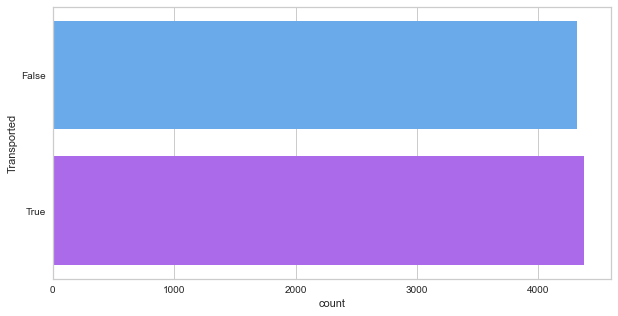

In [414]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['Transported'], palette='cool', orient='h')
plt.show()

## Create features

In [415]:
df_data['Ageismissing'] = df_data['Age'].isnull()
df_data['Ageismissing'] = df_data['Ageismissing'].astype(int)
df_data['Age'].fillna(df_data['Age'].mean(), inplace=True)

df_data['RoomService'].fillna(0, inplace=True)
df_data['PaidRoomService'] = df_data['RoomService'] > 0
df_data['PaidRoomService'] = df_data['PaidRoomService'].astype(int)


df_data['FoodCourt'].fillna(0, inplace=True)
df_data['PaidFoodCourt'] = df_data['FoodCourt'] > 0
df_data['PaidFoodCourt'] = df_data['PaidFoodCourt'].astype(int)

df_data['ShoppingMall'].fillna(0, inplace=True)
df_data['PaidShoppingMall'] = df_data['ShoppingMall'] > 0
df_data['PaidShoppingMall'] = df_data['PaidShoppingMall'].astype(int)

df_data['Spa'].fillna(0, inplace=True)
df_data['PaidSpa'] = df_data['Spa'] > 0
df_data['PaidSpa'] = df_data['PaidSpa'].astype(int)


df_data['VRDeck'].fillna(0, inplace=True)
df_data['PaidVRDeck'] = df_data['VRDeck'] > 0
df_data['PaidVRDeck'] = df_data['PaidVRDeck'].astype(int)


df_data['TotalSpend'] = df_data['RoomService'] + df_data['FoodCourt'] + df_data['ShoppingMall'] + df_data['Spa'] + df_data['VRDeck']
df_data['PctRoomService'] = df_data['RoomService']/df_data['TotalSpend']
df_data['PctFoodCourt'] = df_data['FoodCourt']/df_data['TotalSpend']
df_data['PctShoppingMall'] = df_data['ShoppingMall']/df_data['TotalSpend']
df_data['PctSpa'] = df_data['Spa']/df_data['TotalSpend']
df_data['PctVRDeck'] = df_data['VRDeck']/df_data['TotalSpend']
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
df_data[fill_cols] = df_data[fill_cols].fillna(0)


# cabin
df_data.loc[df_data['Cabin'].isnull(), 'Cabin'] = 'None/None/None'
df_data[['deck', 'num','side']] = df_data['Cabin'].str.split('/', expand=True)
df_data['deck']=df_data['deck'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'None':8})
df_data['side']=df_data['side'].replace({'S':0, 'P':1,'None':2})
# HomePlanet
df_data['HomePlanet'].fillna('None', inplace=True)
df_data['HomePlanet'] = df_data['HomePlanet'].map({'Earth': 0, 'Europa': 1,'Mars': 2, 'None': 3})
# Destination
df_data['Destination'].fillna('None', inplace=True)
df_data['Destination'] = df_data['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,'TRAPPIST-1e': 2, 'None': 3})

df_data['group']=df_data['PassengerId'].apply(lambda x: x.split('_')[0])

# PassengerId
df_data.drop('PassengerId', axis=1, inplace=True)


# CryoSleep & VIP
df_data['CryoSleep'] = df_data['CryoSleep'].fillna(False)
df_data['VIP'] = df_data['VIP'].fillna(False)

bool_type = ['VIP', 'CryoSleep']
df_data[bool_type] = df_data[bool_type].astype(int)
df_data['PaidVRDeck'] = df_data['PaidVRDeck'].astype(int)

df_data['deck'] = df_data['Cabin'].apply(lambda x: x.split('/')[0])
df_data['num'] = df_data['Cabin'].apply(lambda x: x.split('/')[1])
df_data['side'] = df_data['Cabin'].apply(lambda x: x.split('/')[2])

df_data.drop('Cabin', axis=1, inplace=True)

df_data['Adult']=True
df_data.loc[df_data['Age']<18, 'Adult']=False
df_data['Name']=df_data['Name'].fillna(method='ffill')
df_data['Under15'] = df_data['Age'].apply(lambda x: 1 if x < 15 else 0)


temp=pd.DataFrame(df_data.groupby(['group'])['Name'])
d={}
for i in range(len(temp)):#len(temp)
    past_last_names=[]
    names=list(temp[1][i])
    rltvs=1
    for j in range(len(list(temp[1][i]))):#len(list(temp[1][i]))
        if(names[j].split(' ')[1] in past_last_names):
            rltvs+=1
        past_last_names.append(names[j].split(' ')[1])

    d[f"{temp[0][i]}"]=rltvs

df_data['has_relatives']=df_data['group'].map(d)

# # Name
df_data.drop('Name', axis=1, inplace=True)



# # # Mean, median, maximum, minimum congestion per roadway / time
# keys = ['roadway','hour', 'minute']
# df = df_data.groupby(by=keys).mean().reset_index().set_index(keys)
# df['mean congestion'] = df['congestion']
# df_data = df_data.merge(df['mean congestion'], how='left', left_on=keys, right_on=keys)

# df = df_data.groupby(by=keys).median().reset_index().set_index(keys)
# df['median congestion'] = df['congestion']
# df_data = df_data.merge(df['median congestion'], how='left', left_on=keys, right_on=keys)

# df = df_data.groupby(by=keys).min().reset_index().set_index(keys)
# df['min congestion'] = df['congestion']
# df_data = df_data.merge(df['min congestion'], how='left', left_on=keys, right_on=keys)

# df = df_data.groupby(by=keys).max().reset_index().set_index(keys)
# df['max congestion'] = df['congestion']
# df_data = df_data.merge(df['max congestion'], how='left', left_on=keys, right_on=keys)




from sklearn.preprocessing import LabelEncoder
qualitative = [col for col in df_data if df_data[col].dtype == 'object']
for feature in qualitative:
    if feature != "Transported":
        df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!memory reduction    
df_data = reduce_mem_usage(df_data)

df_train = df_data[df_data.Transported.isnull() == False]
df_test = df_data[df_data.Transported.isnull() == True]

df_train['Transported'] = df_train['Transported'].astype(int)
df_test = df_test.drop(['Transported'],axis=1)

X = df_train.drop('Transported', axis=1)
y = df_train['Transported']

print(df_train.shape, df_test.shape)

Mem. usage decreased to  1.03 Mb (57.0% reduction)
(8693, 30) (4277, 29)


In [416]:
df_data.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PctShoppingMall,PctSpa,PctVRDeck,deck,num,side,group,Adult,Under15,has_relatives
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1,0,1,0,True,0,1
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,...,0.033967,0.745924,0.059783,5,0,2,1,True,0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,...,0.000000,0.646730,0.004719,0,0,2,2,True,0,2
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,...,0.071677,0.643161,0.037287,0,0,2,2,True,0,2
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,...,0.138405,0.517874,0.001833,5,1,2,3,False,0,1


In [417]:
df_test.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PctShoppingMall,PctSpa,PctVRDeck,deck,num,side,group,Adult,Under15,has_relatives
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,6,1117,2,12,True,0,1
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,...,0.000000,0.996822,0.000000,5,1228,2,17,True,0,1
2,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,2,0,2,18,True,0,1
3,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,...,0.000000,0.024400,0.078862,2,1,2,20,True,0,1
4,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,...,0.984496,0.000000,0.000000,5,1339,2,22,True,0,1


## Mutual Information

In [418]:
# # see best parameters by mutial information
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBRegressor

# def make_mi_scores(X, y):
#     X = X.copy()
#     for colname in X.select_dtypes(["object"]):
#         X[colname], _ = X[colname].factorize()
#     # All discrete features should now have integer dtypes
#     #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
#     mi_scores = mutual_info_regression(X, y, random_state=0)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# y = df_data[df_data['Transported'].isnull() == False]['Transported']
# x = df_data[df_data['Transported'].isnull() == False].drop('Transported', axis=1)
# mi_scores = make_mi_scores(x, y)
# mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'Feature'})

In [419]:
# fig = px.bar(mi_scores, x='MI Scores', y='Feature', color="MI Scores",
#              color_continuous_scale='darkmint')
# fig.update_layout(height = 750, title_text="Mutual Information Scores",
#                   title_font=dict(size=29, family="Lato, sans-serif"), xaxis={'categoryorder':'category ascending'}, margin=dict(t=80))

In [420]:
# plt.figure(figsize=(17,17))
# corr=df_data.corr(method='spearman')
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(30, 20))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# # Draw the heatmap with the mask and correct aspect ratio
# g=sns.heatmap(corr, mask=mask,annot=True,cmap="YlGnBu", vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## PCA

In [421]:
# from sklearn.preprocessing import StandardScaler 
# train_standard = StandardScaler().fit_transform(train)

# train_standard = pd.DataFrame(train_standard, index=train.index, columns=train.columns)
# train_standard.head(2)

In [422]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(train_standard)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
# principalDf.head(2)

In [423]:
# pca.explained_variance_ratio_

In [424]:
# print(np.cumsum((pca.explained_variance_ratio_)))

In [425]:
# train = pd.concat([train, principalDf], axis = 1)
# train.head(2)

In [426]:
# # test
# test_standard = StandardScaler().fit_transform(test)
# test_standard = pd.DataFrame(test_standard, index=test.index, columns=test.columns)


# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(test_standard)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
# test = pd.concat([test, principalDf], axis = 1)

In [427]:
# print(np.cumsum((pca.explained_variance_ratio_)))

In [428]:
# print(train.shape, test.shape)

# Modeling

## CV

In [429]:
def scikit_grid():
    from sklearn.model_selection import GridSearchCV
    from catboost import CatBoostClassifier
    parameters = {'depth'         : [4,6,10],
                     'learning_rate' : [0.01,0.05],
                      'iterations'    : [500, 1000, 1500]
                     }
    CBC = CatBoostClassifier(task_type="GPU",devices='0:1', verbose=True)
    Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3)

    Grid_CBC.fit(X, y)

    # print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
    print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
# scikit_grid()

In [430]:
stop

NameError: name 'stop' is not defined

In [ ]:
from catboost import CatBoostClassifier
import statistics

scores_on_split = []
for N_SPLITS in range(105,121,5):

    #N_SPLITS = 5 # 200 is the best score on LB
    RANDOM_STATE = 42 
    params = {
           'n_estimators' : N_ESTIMATORS,
            'n_jobs' : -1,
             'random_state' : RANDOM_STATE
    }

    scores = []
    y_probs = []
    y_probs_final = []

    print('Total splits: ', N_SPLITS)
    folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

    for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  

        print("fold : ", fold + 1, end = ' ')

        X_train = X.iloc[train_id]
        y_train = y.iloc[train_id]
        X_valid = X.iloc[test_id]
        y_valid = y.iloc[test_id]

        # model_2
        model =  CatBoostClassifier(verbose=False)
        model.fit(X_train, y_train)

        # validation
        valid_pred = model.predict(X_valid)
        valid_score = accuracy_score(y_valid, valid_pred)
        print( "Validation score: ", valid_score, end = ' ')
        scores.append(valid_score)

        # test
        #y_pred = model.predict(df_test)
        y_probs.append(model.predict_proba(df_test))
        print("")
    scores_on_split.append(statistics.mean(scores))


scores_on_split

Total splits:  105
fold :  1 Validation score:  0.8192771084337349 
fold :  2 Validation score:  0.8072289156626506 
fold :  3 Validation score:  0.7469879518072289 
fold :  4 Validation score:  0.8072289156626506 
fold :  5 Validation score:  0.8192771084337349 
fold :  6 Validation score:  0.7951807228915663 
fold :  7 Validation score:  0.7469879518072289 
fold :  8 Validation score:  0.8072289156626506 
fold :  9 Validation score:  0.7108433734939759 
fold :  10 Validation score:  0.8072289156626506 
fold :  11 Validation score:  0.8192771084337349 
fold :  12 Validation score:  0.7951807228915663 
fold :  13 Validation score:  0.8674698795180723 
fold :  14 Validation score:  0.7590361445783133 
fold :  15 Validation score:  0.7831325301204819 
fold :  16 Validation score:  0.7951807228915663 
fold :  17 Validation score:  0.8192771084337349 
fold :  18 Validation score:  0.7590361445783133 
fold :  19 Validation score:  0.8072289156626506 
fold :  20 

In [447]:
# 0.8153986928104575 - 500

# 0.8167548783747661 - 100
# 0.8182521395655036 - 140
# 0.8187900786448881 - 150
# 0.8169900557846228 - 155
# 0.8145664983164983 - 160
# 0.8175317124735729 - 200
import statistics
statistics.mean(scores)

0.8135351510291365

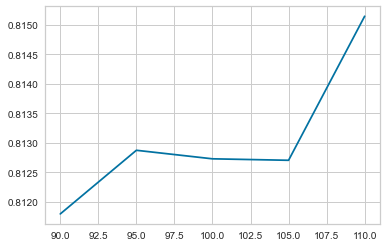

In [453]:
i = np.arange(105,121,5)
plt.plot(i, scores_on_split)

## Catboost

In [ ]:
model =  CatBoostClassifier(depth=12,verbose=False)
model.fit(train,y)
model.score(train,y)

In [ ]:
y_pred = model.predict(test)
y_pred

## Pycaret

In [ ]:
from pycaret.classification import *
#num_cols = list(train.select_dtypes('float64').columns) + list(train.select_dtypes('int64').columns)

s = setup(data = df_train,
          target = 'Transported',
          train_size = 0.8,
          fold_strategy = 'stratifiedkfold',
          fold = 5,
          fold_shuffle = True,
          #numeric_features = num_cols,
          ignore_low_variance=True,
          remove_multicollinearity = True,
          imputation_type='iterative',
          #normalize = True,
          normalize_method = 'robust',
          data_split_stratify = True,
          #ignore_features = ['PassengerNo', 'Name', 'PassengerId', 'PassengerGroup', 'Cabin'],
          silent = True)

In [ ]:
best_model = compare_models()

In [ ]:
catboost_m = create_model('catboost')

In [ ]:
tuned_catboost = tune_model(catboost_m, optimize = 'Accuracy')

In [ ]:
#plot_model(catboost_m, plot = 'parameter')

In [ ]:
# plot_model(tuned_catboost, plot = 'parameter')

# Submission

In [ ]:
sub.head(2)

In [ ]:
# # y_pred = predict_model(lr, data=test)
# # y_pred = y_pred['Label']


# preds = []
# for i in y_pred:
#     if i == 0:
#         preds.append(False)
#     else:
#         preds.append(True)

# sub['Transported'] = preds

# sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
# sub.head()

In [ ]:
y_probs_final = sum(y_probs) / len(y_probs)
y_probs_final

preds = []
for i in y_probs_final:
    if i[0] > i[1]:
        preds.append(False)
    else:
        preds.append(True)
        
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["Transported"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("E:/downloads/sample_submission.csv", index=False)
    return sub
save_submission(preds).head(3)

# Exponentially weighted ensemble:

In [ ]:
sub = pd.read_csv(cwd + "/spaceship/sample_submission.csv")
sub.sort_values(by=['PassengerId'], inplace=True)
sub['Transported'] = sub['Transported'].astype('float')
sub.head(10)

In [ ]:
sub.sort_values(by=['PassengerId'], inplace=True)
sub['Transported'] = sub['Transported'].astype('float')

In [ ]:
import os
for dirname, _, filenames in os.walk('C:/Users/misha/Desktop/sample_project_1/spaceship'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
b = 1000.0
S = 0.81014
q = 0.0

In [ ]:
sub1 = pd.read_csv('C:/Users/misha/Desktop/sample_project_1/spaceship/sample_submission_mine.csv')
sub1.sort_values(by=['PassengerId'], inplace=True)
sub1['Transported'] = sub1['Transported'].astype('float')

sub2 = pd.read_csv('C:/Users/misha/Desktop/sample_project_1/spaceship/sample_submission_flaml.csv')
sub2.sort_values(by=['PassengerId'], inplace=True)
sub2['Transported'] = sub2['Transported'].astype('float')


sub3 = pd.read_csv('C:/Users/misha/Desktop/sample_project_1/spaceship/submission_pycaret4.csv')
sub3.sort_values(by=['PassengerId'], inplace=True)
sub3['Transported'] = sub3['Transported'].astype('float')


sub4 = pd.read_csv('C:/Users/misha/Desktop/sample_project_1/spaceship/sample_project_1submission_5.csv')
sub4.sort_values(by=['PassengerId'], inplace=True)
sub4['Transported'] = sub4['Transported'].astype('float')

sub5 = pd.read_csv('C:/Users/misha/Desktop/sample_project_1/spaceship/submission6.csv')
sub5.sort_values(by=['PassengerId'], inplace=True)
sub5['Transported'] = sub5['Transported'].astype('float')

# sub6 = pd.read_csv('../input/spaceship-titanic-models/80687_submission_v11.csv')
# sub6.sort_values(by=['PassengerId'], inplace=True)
# sub6['Transported'] = sub6['Transported'].astype('float')
# sub7 = pd.read_csv('../input/spaceship-titanic-models/80640_submission_v16.csv')
# sub7.sort_values(by=['PassengerId'], inplace=True)
# sub7['Transported'] = sub7['Transported'].astype('float')
# sub8 = pd.read_csv('../input/spaceship-titanic-models/80617_submission_stack_v55.csv')
# sub8.sort_values(by=['PassengerId'], inplace=True)
# sub8['Transported'] = sub8['Transported'].astype('float')
# sub9 = pd.read_csv('../input/spaceship-titanic-models/80593_submission_v24.csv')
# sub9.sort_values(by=['PassengerId'], inplace=True)
# sub9['Transported'] = sub9['Transported'].astype('float')
# sub10 = pd.read_csv('../input/spaceship-titanic-models/80570_submission_v9.csv')
# sub10.sort_values(by=['PassengerId'], inplace=True)
# sub10['Transported'] = sub10['Transported'].astype('float')
# sub11 = pd.read_csv('../input/spaceship-titanic-models/80500_submission_v4.csv')
# sub11.sort_values(by=['PassengerId'], inplace=True)
# sub11['Transported'] = sub11['Transported'].astype('float')
# sub12 = pd.read_csv('../input/spaceship-titanic-models/78419_submission_v9.csv')
# sub12.sort_values(by=['PassengerId'], inplace=True)
# sub12['Transported'] = sub12['Transported'].astype('float')
# sub13 = pd.read_csv('../input/spaceship-titanic-models/76689_submission_knn_v3.csv')
# sub13.sort_values(by=['PassengerId'], inplace=True)
# sub13['Transported'] = sub13['Transported'].astype('float')

In [ ]:
sub['Transported'] = sub1['Transported']*np.exp(b*(0.81014-S))
q = q + np.exp(b*(0.81014-S))

sub['Transported'] = sub['Transported'] + sub2['Transported']*np.exp(b*(0.80921-S))
q = q + np.exp(b*(0.80921-S))

sub['Transported'] = sub['Transported'] + sub3['Transported']*np.exp(b*(0.80804-S))
q = q + np.exp(b*(0.80804-S))

sub['Transported'] = sub['Transported'] + sub4['Transported']*np.exp(b*(0.80710-S))
q = q + np.exp(b*(0.80710-S))

sub['Transported'] = sub['Transported'] + sub5['Transported']*np.exp(b*(0.80687-S))
q = q + np.exp(b*(0.80687-S))

# sub['Transported'] = sub['Transported'] + sub6['Transported']*np.exp(b*(0.80687-S))
# q = q + np.exp(b*(0.80687-S))
# sub['Transported'] = sub['Transported'] + sub7['Transported']*np.exp(b*(0.80640-S))
# q = q + np.exp(b*(0.80640-S))
# sub['Transported'] = sub['Transported'] + sub8['Transported']*np.exp(b*(0.80617-S))
# q = q + np.exp(b*(0.80617-S))
# sub['Transported'] = sub['Transported'] + sub9['Transported']*np.exp(b*(0.80593-S))
# q = q + np.exp(b*(0.80593-S))
# sub['Transported'] = sub['Transported'] + sub10['Transported']*np.exp(b*(0.80570-S))
# q = q + np.exp(b*(0.80570-S))
# sub['Transported'] = sub['Transported'] + sub11['Transported']*np.exp(b*(0.80500-S))
# q = q + np.exp(b*(0.80500-S))
# sub['Transported'] = sub['Transported'] + sub12['Transported']*np.exp(b*(0.78419-S))
# q = q + np.exp(b*(0.78419-S))
# sub['Transported'] = sub['Transported'] + sub13['Transported']*np.exp(b*(0.76689-S))
# q = q + np.exp(b*(0.76689-S))
sub['Transported'] = sub['Transported']/q
print(q)
sub.head()

In [ ]:
sub['Transported'] = np.rint(sub['Transported'])
sub.head(10)

In [ ]:
sub['Transported'] = sub['Transported'].astype('bool')
sub.to_csv('E:/downloads/sample_submission.csv', index=False)
sub.head(10)